<a href="https://colab.research.google.com/github/0-lingual/Deepfake-Detection-CNN/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning을 이용한 이미지 분류기(Dataset2)**

In [ ]:
# Kaggle API 설치
!pip install kaggle

# Kaggle API 토큰 업로드
from google.colab import files
files.upload()  # 여기서 kaggle.json 파일을 업로드합니다.

# Kaggle API 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 데이터셋 다운로드
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

# 압축 해제
!unzip -o deepfake-and-real-images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  
  inflating: D

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
from pathlib import Path
import pandas as pd
import os

def image_to_df(filepaths):
  # Extract the labels from the filepaths
  labels = [str(filepath).split(".")[-2].split("/")[-1].split("_")[0] for filepath in filepaths]

  # Create a pandas Series for the filepaths and labels
  filepath = pd.Series(filepaths, name='Data').astype(str)
  labels = pd.Series(labels, name='Label')

  # Combine the Series into a DataFrame
  df = pd.concat([filepath, labels], axis=1)

  return df

# Set the data path
data_path = "/content/Dataset"

# Get the paths to the Train, Test, and Validation directories
train_path = os.path.join(data_path, "Train")
test_path = os.path.join(data_path, "Test")
val_path = os.path.join(data_path, "Validation")

# Get the paths to the Real and Fake directories within each of the above directories
train_real_path = os.path.join(train_path, "Real")
train_fake_path = os.path.join(train_path, "Fake")
test_real_path = os.path.join(test_path, "Real")
test_fake_path = os.path.join(test_path, "Fake")
val_real_path = os.path.join(val_path, "Real")
val_fake_path = os.path.join(val_path, "Fake")

# Get the filepaths for all the images in each of the Real and Fake directories
train_real_filepaths = list(Path(train_real_path).glob(r'**/*.jpg'))
train_fake_filepaths = list(Path(train_fake_path).glob(r'**/*.jpg'))
test_real_filepaths = list(Path(test_real_path).glob(r'**/*.jpg'))
test_fake_filepaths = list(Path(test_fake_path).glob(r'**/*.jpg'))
val_real_filepaths = list(Path(val_real_path).glob(r'**/*.jpg'))
val_fake_filepaths = list(Path(val_fake_path).glob(r'**/*.jpg'))

# Combine the filepaths into a single list
filepaths = train_real_filepaths + train_fake_filepaths + test_real_filepaths + test_fake_filepaths + val_real_filepaths + val_fake_filepaths

df = image_to_df(filepaths)

In [ ]:
# @title 데이터와 라벨 확인
print(f'Number of training pictures : {df.shape[0]}\n')
print(f'Number of training labels : {df.shape[1]}\n')

Number of training pictures : 190335

Number of training labels : 2



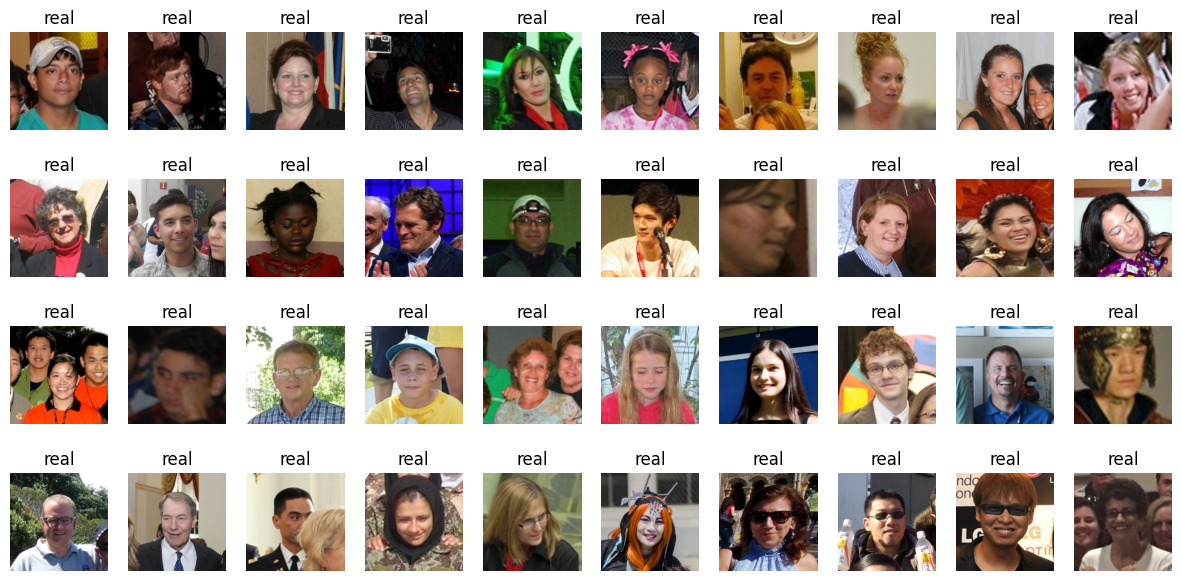

In [ ]:
import matplotlib.pyplot as plt

# @title train data 출력
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df['Data'].iloc[i]))
  ax.set_title(df['Label'].iloc[i])
  ax.axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# @title train, test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)
train_df.shape, test_df.shape

((171301, 2), (19034, 2))

# **data augmentation으로 모델 성능 높이기**

In [ ]:
def create_gen():
  train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
      validation_split=0.2
  )

  test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

  train_image = train_generator.flow_from_dataframe(
      dataframe=train_df, x_col="Data", y_col="Label", target_size=(224,224), class_mode='binary',
      rescale=1./255, vertical_flip=True, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
      fill_mode="nearest", subset='training', batch_size=32, shuffle=True)

  val_image = train_generator.flow_from_dataframe(
      dataframe=train_df, x_col="Data", y_col="Label", target_size=(224,224), class_mode='binary',
      rescale=1./255, vertical_flip=True, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
      fill_mode="nearest", subset='validation', batch_size=32, shuffle=False
  )

  test_image = test_generator.flow_from_dataframe(
      dataframe=test_df, x_col='Data', y_col='Label', target_size=(224,224), class_mode='binary',
      shuffle=False, batch_size=32
  )

  return train_generator, test_generator, train_image, val_image, test_image

train_generator,test_generator,train_images,val_images,test_images = create_gen()

Found 137041 validated image filenames belonging to 2 classes.
Found 34260 validated image filenames belonging to 2 classes.
Found 19034 validated image filenames belonging to 2 classes.


# **전이학습을 이용해 모델 성능 높이기**

In [ ]:
# @title transfer learning
# @title transfer learning
models = {
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
}

def get_model(model):
  kwargs = {'input_shape' :(224, 224, 3),
            'include_top':False,
            'pooling':'avg'}
  pretrained_model = model(**kwargs)
  pretrained_model.trainable = False
  inputs = pretrained_model.input

  x = tf.keras.layers.Dense(units=64, activation='relu')(pretrained_model.output)
  x = tf.keras.layers.Dense(units=64, activation='relu')(x)S
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])
  return model

In [ ]:
# Train모델 학습
model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images, validation_data=val_images, epochs=5)

Epoch 1/5
4283/4283 [==============================] - 1076s 251ms/step - loss: 0.4504 - accuracy: 0.7796 - val_loss: 0.4368 - val_accuracy: 0.7901
Epoch 2/5
4283/4283 [==============================] - 1024s 239ms/step - loss: 0.4138 - accuracy: 0.8022 - val_loss: 0.4337 - val_accuracy: 0.7909
Epoch 3/5
4283/4283 [==============================] - 1035s 242ms/step - loss: 0.3962 - accuracy: 0.8123 - val_loss: 0.4050 - val_accuracy: 0.8087
Epoch 4/5
4283/4283 [==============================] - 1031s 241ms/step - loss: 0.3829 - accuracy: 0.8204 - val_loss: 0.4004 - val_accuracy: 0.8118
Epoch 5/5
4283/4283 [==============================] - 1060s 248ms/step - loss: 0.3698 - accuracy: 0.8269 - val_loss: 0.4089 - val_accuracy: 0.8054


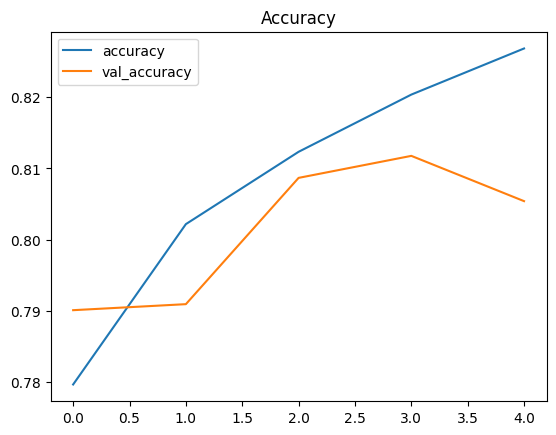

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = (pred > 0.5).astype(int).flatten()

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

595/595 [==============================] - 131s 219ms/step
Accuracy on the test set: 80.91%
